In [1]:
import sys
sys.path.append("classical")

In [2]:
import itertools

def get_pauli_dicts(nqbits):
    pauli_indices = [0,1,2,3]
    pauli_pairs = list(itertools.product(pauli_indices, repeat=nqbits))
    pauli_pair_dict = pauli_pair_dict = {pauli_pairs[i] : i for i in range(len(pauli_pairs))}
    return pauli_pairs, pauli_pair_dict

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm 
from binary_functions import Int2Bas,Bas2Int,Opp2Str,Str2Opp
from Pmn import PPmunu

In [4]:
def lie_algebra(mu,nu,n):
    # Return coefficients and index for sigma mu,sigma nu
    index = ''
    coeff = 1
    for i in range(n):
        tmpA,tmpB = PPmunu(mu[i]+nu[i])
        index += tmpA
        coeff *= tmpB
    return coeff,Bas2Int(Str2Opp(index),4)

In [5]:
def get_index_coeff(n):
    index = np.zeros([4**n,4**n],dtype=int)
    coeff = np.zeros([4**n,4**n],dtype=complex)
    for i in range(4**n):
        for j in range(4**n):
            coeff[i,j],index[i,j] = lie_algebra(Opp2Str(Int2Bas(i,4,n)),Opp2Str(Int2Bas(j,4,n)),n)
    return index,coeff

### Define Hamiltonian in explicit matrix form for classical simulation

In [6]:
t = 1.0
U = 2.0

sigma = np.zeros([2, 2, 4], dtype=complex)
sigma[0, 0, 0] = 1.
sigma[1, 1, 0] = 1.
sigma[0, 1, 1] = 1.
sigma[1, 0, 1] = 1.
sigma[0, 1, 2] = -1j
sigma[1, 0, 2] = 1j
sigma[0, 0, 3] = 1.
sigma[1, 1, 3] = -1.
# N = 10 # Number of imaginary time steps

pauliI, pauliX, pauliY, pauliZ = (sigma[:, :, 0], sigma[:, :, 1], sigma[:, :, 2], sigma[:, :, 3])
ii = np.kron(sigma[:, :, 0], sigma[:, :, 0])
ix = np.kron(sigma[:, :, 0], sigma[:, :, 1])
iy = np.kron(sigma[:, :, 0], sigma[:, :, 2])
iz = np.kron(sigma[:, :, 0], sigma[:, :, 3])
xi = np.kron(sigma[:, :, 1], sigma[:, :, 0])
yi = np.kron(sigma[:, :, 2], sigma[:, :, 0])
zi = np.kron(sigma[:, :, 3], sigma[:, :, 0])
xx = np.kron(sigma[:, :, 1], sigma[:, :, 1])
yy = np.kron(sigma[:, :, 2], sigma[:, :, 2])
zz = np.kron(sigma[:, :, 3], sigma[:, :, 3])
zx = np.kron(sigma[:, :, 3], sigma[:, :, 1])
xz = np.kron(sigma[:, :, 1], sigma[:, :, 3])


# Hamiltonian = -t * (xi + ix) + (U / 2) * (ii + zz)
Hamiltonian = 3*xx + zi + iz
# Hamiltonian = -t * (np.kron(xi,ii) + np.kron(ix,ii)) + (U / 2) * (np.kron(ii,ii) + np.kron(zz,ii))
# Hamiltonian = -t * (zx + ix) + (U / 2) * (ii + zz)
# Hamiltonian = a*xi + b*zi

### QITE and Correlation Function parameters

In [7]:
nqbits = 2

beta = 0.2

# Unitary time evolution settings, subroutine of correlation function computation
N_time = 40
dtime = 0.10 * np.pi
tot_time = N_time * dtime

In [8]:
index, coeff = get_index_coeff(nqbits)

In [9]:
pauli_pairs, pauli_pair_dict = get_pauli_dicts(nqbits)

In [13]:
def plot_corr_func(xseries, corr_expectation_list):
    real = np.array(corr_expectation_list)[:,0]
    imaginary = np.array(corr_expectation_list)[:,1]
    plt.figure(figsize=[8,4], dpi=150)

    from scipy import optimize

#     def test_func(x, a, b):
#         return a * np.sin(b * x)

#     params_real, params_covariance_real = optimize.curve_fit(test_func, xseries, real[0],
#                                                    p0=[2, 2])
    
    if len(corr_expectation_list) > 1:
        for i in range(len(res_list)):
            re = real[i]
            im = imaginary[i]
            plt.plot(xseries,re,'-r',alpha=0.1)
            plt.plot(xseries,im,'-r',alpha=0.1)
            

        plt.plot(xseries,np.average(real,axis=0),'-r.', label="Real")
        plt.plot(xseries,np.average(imaginary,axis=0),'-b.', label="Imaginary")

    else:
#         plt.plot(xseries,test_func(xseries, params_real[0], params_real[1]),'-r.', label="Real")
        plt.plot(xseries,real[0],'-r.', label="Real")
        plt.plot(xseries,imaginary[0],'-b.', label="Imaginary")

#     plt.axhline(y=w[0], color='k',linestyle='--',label="Ground state")
#     plt.title("Correlation Function")
#     plt.xlabel("Time")
#     plt.ylabel("Function")
    plt.grid()
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.show()

## Classical computation

In [20]:
N_qite = 2
db = 0.2

energy_classical_thermal_list = []

for i in range(0,N_qite+1):
    gibbs = expm(-Hamiltonian * i*db)
    norm_gibbs = np.trace(gibbs)
    gibbs /= norm_gibbs
#     print(gibbs)
    thermal_energy = np.trace(np.matmul(gibbs, Hamiltonian)).real
    energy_classical_thermal_list.append(thermal_energy)
    
print(energy_classical_thermal_list)
print("thermal energy at {}: {}".format(beta,energy_classical_thermal_list[-1]))

[0.0, -1.9297365992607576, -2.9001948734322975]
thermal energy at 0.2: -2.9001948734322975


In [14]:
gibbs = expm(-Hamiltonian * beta)
norm_gibbs = np.trace(gibbs)
gibbs /= norm_gibbs

# for each trial
corr_func_exp_lst = []
# for real
corr_func_exp_lst.append([])
# for imaginary
corr_func_exp_lst.append([])

for i in range(N_time + 1):
    # time evolve for time i * dtime
    time_ev_op = expm(-1j * Hamiltonian * i*dtime)
    time_ev_op_T = expm(1j * Hamiltonian * i*dtime)
    zi_t = np.matmul(time_ev_op_T,zi,time_ev_op)
    corr_op = np.matmul(zi_t,zi)
    corr_func_exp = np.trace(np.matmul(gibbs,corr_op))
#     corr_func_exp_lst.append(corr_func_exp)
    corr_func_exp_lst[0].append(np.real(corr_func_exp))
    corr_func_exp_lst[1].append(np.imag(corr_func_exp))

Inverse temperature:  0.2


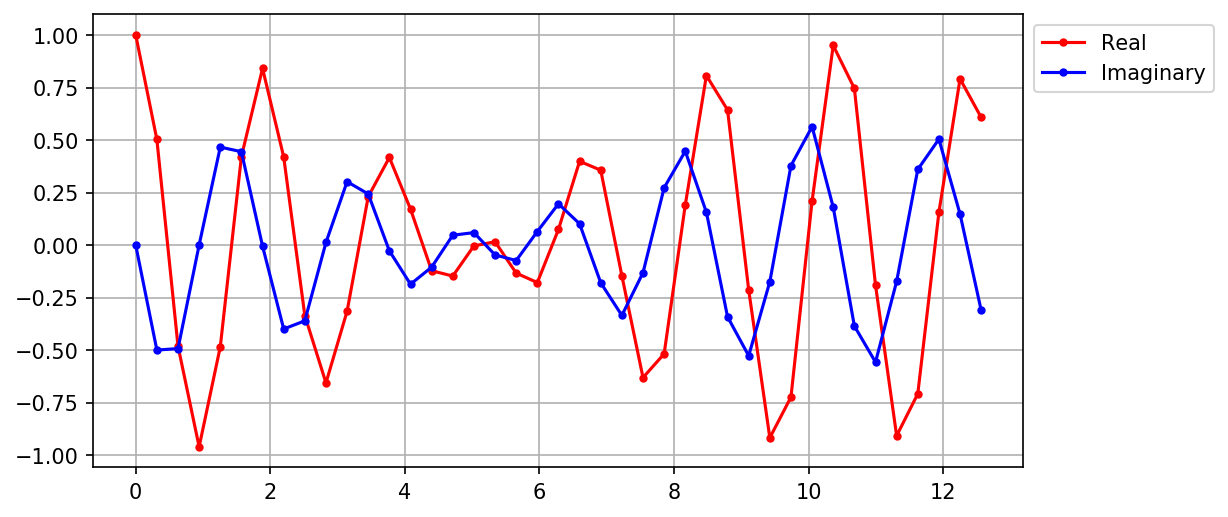

In [15]:
print("Inverse temperature: ", beta)
plot_corr_func(np.arange(0,N_time+1)*dtime, [corr_func_exp_lst])